<a href="https://colab.research.google.com/github/dongchanlim/SCCU_capstone_S25/blob/main/SCCU_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Swire Coca-Cola USA (SCCU) - Modeling Notebook

## Introduction
This notebook includes the pipeline to predict the growth potential customer with ML framework & the analytical decision modeling to find the optimized threshold.

## Main questions

-   (Richard Lim) What factors or characteristics distinguish customers with annual sales exceeding the determined volume threshold from those below this threshold?

   - 2023 (Below vs Above): figure out factors  differing between above vs below group
   - 2024 (Below vs Above): figure out factors differing between above vs below group

-   (Varun Selvam) How can SCCU uses historical sales data, or other Customer Characteristics to predict which ARTM customers have the potential to grow beyond the volume threshold annually?


  - Which customer characteristics contribute to move customers from below threshold (2023) to above threshold (2024)?

-   (Meenakshi Raj) How can these insights be integrated into the routing strategy to support long-term growth while maintaining logistical efficiency?

  - logistical efficiency represents how much we can save delivery cost at maximum while increasing the number of growth customer (Below to Above Group)

-   (Nikita Muddapati) What levers can be employed to accelerate volume and share growth at growth-ready, high-potential customers?

  - Business Recommendation: accurate number + storytelling to take action
  - Question: which threshold should be used for new logistical efficiency?
  - Reason: Reasoning why the threshold is better than original one (400 annual threshold)

# Requirement

- A statement of the business and analytic problems for the project.
- Documentation of your modeling process (as well as any additional data cleaning and preparation you did) along with an interpretation of your results.  This writing belongs in the main sections of the notebook dedicated to the modeling process, and should go between code chunks.
- Code annotation.  This writing goes within code chunks, and should explain what the code is doing.
- All the performance metrics for the best model: in-sample and estimated out-of-sample performance.
- A results section at the end where you summarize the key points of what you have learned through the group modeling process. Can modeling results be used to solve the business problem?

# Thing to consider in modeling

- Identify a performance benchmark.  What is a minimum threshold for model performance?
- Identify appropriate models to explore (given the business problem and the project objective).
- Do additional data preparation and feature engineering as necessary.
Perform cross-validation to develop performance metrics for each model, appropriate for the context.
- Optimize model performance with hyperparameter tuning, if appropriate.
- Evaluate the strengths and weaknesses of each model and select the best one.
- Perform business validation of the model.  Are your results sufficient to solve the business problem?

**Business Problem**

SCCU(Swire Coca-Cola United States) tries to optimize logistics by transitioning customers selling below a specific annual volume to an Alternate Route to Market (ARTM). There is an annual 400 gallons volume threshold used to distinguish the customers between the direct delivery route and ARTM.

However, SCCU is looking for a more cost-efficient strategy to decide new threshold for optimizing logistics which is driving better operational efficiency and more revenues.


**Analytical Approach**

This analysis will focus on building the classification model to predict who is going to be a growth customer segment (those who were below the threshold from 2023 but becoming above the threshold on following year (2024)) based on the 2023 historical data only, and which volume threshold would be more optimal compared to original threshold.

**Modeling Processes**

1. Setting up the ML pipeline classes
2. Loading the dataset and checkout data profile
3. Identifying the benchmark performance of original threshold
4. Genenrating the classification model to predict the growth customer group
5. Selecting and engineering the variables used in the modeling
6. Training and evaluating the performance between the models and select the best model
7. Generating the comparison metrics between new threshold and old threshold

**Result**




## Import libaries

In [ ]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

import pickle
import joblib
import warnings

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

## ML model Class



In [ ]:
class SCCURoutingOptimizer:
    """
    ML pipeline for SCCU route optimization:
    1. Predicts growth potential for ARTM customers
    2. Identifies optimal thresholds for routing decisions
    3. Provides actionable business insights
    """

    def __init__(self, data_path='sccu_data.csv'):
        """Initialize with path to data file"""
        self.data_path = data_path
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.models = {}
        self.best_model = None

    # Define the lambda function inside the method
    @staticmethod
    def bool_to_int_func(x):
        return x.astype(int)

    def load_data(self):
        """Load and perform initial data processing"""
        print("1. Loading and preprocessing data")

        # Load data
        self.data = pd.read_csv(self.data_path)

        # Basic info
        print(f"Dataset shape: {self.data.shape}")
        print(f"Missing values:\n{self.data[self.data.columns[self.data.isnull().sum() > 0]].isnull().sum()}")

        # Analyze current thresholds
        print("\n3.Analyzing current thresholds...")
        self.analyze_current_thresholds()

        return self.data

    def create_derived_features(self):
        """Create additional features for analysis and prediction"""

        # Target variable for growth prediction: Did customer move from below to above threshold?
        self.data['GROWTH_TARGET'] = ((self.data['THRESHOLD_2023'] == 'below') &
                                    (self.data['THRESHOLD_2024'] == 'above')).astype(int)

        # Print derived features
        print(f"Added derived 1 variables. New shapes are: {self.data.shape}")

    def analyze_current_thresholds(self, number = 400):
        """Analyze the current threshold strategy effectiveness"""

        # Calculate additional derived features
        print("\n2.Creating derived features...")
        self.create_derived_features()

        # Current distribution
        print(f"\n{number} Annual Threshold distribution:")
        below_threshold_2023 = (self.data['THRESHOLD_2023'] == 'below').sum()
        above_threshold_2023 = (self.data['THRESHOLD_2023'] == 'above').sum()
        below_threshold_2024 = (self.data['THRESHOLD_2024'] == 'below').sum()
        above_threshold_2024 = (self.data['THRESHOLD_2024'] == 'above').sum()

        # The number of Customer Movement between thresholds
        below_to_above = ((self.data['THRESHOLD_2023'] == 'below') &
                          (self.data['THRESHOLD_2024'] == 'above')).sum()
        above_to_below = ((self.data['THRESHOLD_2023'] == 'above') &
                          (self.data['THRESHOLD_2024'] == 'below')).sum()
        below_to_below = ((self.data['THRESHOLD_2023'] == 'below') &
                          (self.data['THRESHOLD_2024'] == 'below')).sum()
        above_to_above = ((self.data['THRESHOLD_2023'] == 'above') &
                          (self.data['THRESHOLD_2024'] == 'above')).sum()
        entire = below_to_above + above_to_below + below_to_below + above_to_above

        # Comparison for customers who changed categories
        growth_customers = self.data[self.data['GROWTH_TARGET'] == 1]
        decline_customers = self.data[((self.data['THRESHOLD_2023'] == 'above') &
                                      (self.data['THRESHOLD_2024'] == 'below'))]
        same_above_customer = self.data[(self.data['THRESHOLD_2023'] == 'above') &
                                                    (self.data['THRESHOLD_2024'] == 'above')]
        same_below_customer= self.data[(self.data['THRESHOLD_2023'] == 'below') &
                                                    (self.data['THRESHOLD_2024'] == 'below')]

        print("----------------------------------------------------------")
        print(f"2023: Below threshold: {below_threshold_2023} ({below_threshold_2023/len(self.data)*100:.2f}%), "
              f"Above threshold: {above_threshold_2023} ({above_threshold_2023/len(self.data)*100:.2f}%)")
        print(f"2024: Below threshold: {below_threshold_2024} ({below_threshold_2024/len(self.data)*100:.2f}%), "
              f"Above threshold: {above_threshold_2024} ({above_threshold_2024/len(self.data)*100:.2f}%)")
        print("----------------------------------------------------------")


        print("\nThe number of customer proportion between thresholds:")

        print("----------------------------------------------------------")
        print(f"Below to Above (Growth): {below_to_above} "
              f"({below_to_above/entire * 100:.2f}% of total)")
        print(f"Above to Below (Decline): {above_to_below} "
              f"({above_to_below/entire * 100:.2f}% of total)")
        print(f"Below to Below (No Change): {below_to_below} "
              f"({below_to_below/entire * 100:.2f}% of total)")
        print(f"Above to Above (No Change): {above_to_above} "
              f"({above_to_above/entire * 100:.2f}% of total)")
        print("----------------------------------------------------------")

        # Current threshold analysis
        print("\n3.Current threshold analysis:")

        print(f"\nIf {number} Annual Threshold were applied...")



        print("\n\nVolume Change")

        print("----------------------------------------------------------")

        print("\nTotal annumal volume change from 2023 to 2024")
        print(f"2023: {self.data['ANNUAL_VOLUME_2023'].sum():.2f} units")
        print(f"2024: {self.data['ANNUAL_VOLUME_2024'].sum():.2f} units")
        print(f"Change: {self.data['ANNUAL_VOLUME_2024'].sum() - self.data['ANNUAL_VOLUME_2023'].sum():.2f} units")

        print("----------------------------------------------------------")

        print("\nTotal annual volume change for no change (below to below):")
        print(f"2023: {same_below_customer['ANNUAL_VOLUME_2023'].sum():.2f} units")
        print(f"2024: {same_below_customer['ANNUAL_VOLUME_2024'].sum():.2f} units")
        print(f"Change: {same_below_customer['ANNUAL_VOLUME_2024'].sum() - same_below_customer['ANNUAL_VOLUME_2023'].sum():.2f} units")

        print("\nTotal annual volume change for growth customers (below to above):")
        print(f"2023: {growth_customers['ANNUAL_VOLUME_2023'].sum():.2f} units")
        print(f"2024: {growth_customers['ANNUAL_VOLUME_2024'].sum():.2f} units")
        print(f"Change: {growth_customers['ANNUAL_VOLUME_2024'].sum() - growth_customers['ANNUAL_VOLUME_2023'].sum():.2f} units")

        print("\nTotal annual volume change for no change (above to above):")
        print(f"2023: {same_above_customer['ANNUAL_VOLUME_2023'].sum():.2f} units")
        print(f"2024: {same_above_customer['ANNUAL_VOLUME_2024'].sum():.2f} units")
        print(f"Change: {same_above_customer['ANNUAL_VOLUME_2024'].sum()- same_above_customer['ANNUAL_VOLUME_2023'].sum():.2f} units")

        print("\nTotal annual volume change for decline customers (above to below):")
        print(f"2023: {decline_customers['ANNUAL_VOLUME_2023'].sum():.2f} units")
        print(f"2024: {decline_customers['ANNUAL_VOLUME_2024'].sum():.2f} units")
        print(f"Change: {decline_customers['ANNUAL_VOLUME_2024'].sum() - decline_customers['ANNUAL_VOLUME_2023'].sum():.2f} units")

        print("----------------------------------------------------------")

        print("\n\nDelivery cost change")

        print("----------------------------------------------------------")

        print("\nTotal annumal delivery cost change from 2023 to 2024")
        print(f"2023: ${self.data['DELIVERY_COST_2023'].sum():.2f}")
        print(f"2024: ${self.data['DELIVERY_COST_2024'].sum():.2f}")
        print(f"Change: ${self.data['DELIVERY_COST_2024'].sum() - self.data['DELIVERY_COST_2023'].sum():.2f}")

        print("----------------------------------------------------------")

        print("\nTotal delivery cost change for no change (below to below):")
        print(f"2023: ${same_below_customer['DELIVERY_COST_2023'].sum():.2f}")
        print(f"2024: ${same_below_customer['DELIVERY_COST_2024'].sum():.2f}")
        print(f"Change: ${same_below_customer['DELIVERY_COST_2024'].sum() - same_below_customer['DELIVERY_COST_2023'].sum():.2f}")

        print("\nTotal delivery cost change for growth customers (below to above):")
        print(f"2023: ${growth_customers['DELIVERY_COST_2023'].sum():.2f}")
        print(f"2024: ${growth_customers['DELIVERY_COST_2024'].sum():.2f}")
        print(f"Change: ${growth_customers['DELIVERY_COST_2024'].sum() - growth_customers['DELIVERY_COST_2023'].sum():.2f}")

        print("\nTotal delivery cost change for no change (above to above):")
        print(f"2023: ${same_above_customer['DELIVERY_COST_2023'].sum():.2f}")
        print(f"2024: ${same_above_customer['DELIVERY_COST_2024'].sum():.2f}")
        print(f"Change: ${same_above_customer['DELIVERY_COST_2024'].sum() - same_above_customer['DELIVERY_COST_2023'].sum():.2f}")

        print("\nTotal delivery cost change for decline customers (above to below):")
        print(f"2023: ${decline_customers['DELIVERY_COST_2023'].sum():.2f}")
        print(f"2024: ${decline_customers['DELIVERY_COST_2024'].sum():.2f}")
        print(f"Change: ${decline_customers['DELIVERY_COST_2024'].sum() - decline_customers['DELIVERY_COST_2023'].sum():.2f}")

        print("----------------------------------------------------------")

    def explore_data(self):
        """Perform exploratory data analysis for insights"""

        print("\n4.Exploring data for insights...")

        # Growth customer analysis
        growth_df = self.data[self.data['GROWTH_TARGET'] == 1]
        print(f"\nAnalyzing {len(growth_df)} growth customers (moved from below to above threshold)")

        # Trade channel distribution for growth customers
        trade_channel_growth = growth_df['TRADE_CHANNEL'].value_counts().head(10)
        print("\nTop 10 trade channels for growth customers:")
        print(trade_channel_growth)

        # Calculate growth rate by trade channel
        channel_growth_rates = []
        for channel in self.data['TRADE_CHANNEL'].unique():
            channel_customers = self.data[self.data['TRADE_CHANNEL'] == channel]
            below_customers = channel_customers[channel_customers['THRESHOLD_2023'] == 'below']
            growth_customers = below_customers[below_customers['THRESHOLD_2024'] == 'above']

            if len(below_customers) > 0:
                growth_rate = len(growth_customers) / len(below_customers) * 100
                channel_growth_rates.append((channel, len(below_customers), len(growth_customers), growth_rate))

        # Sort by growth rate and show top channels
        channel_growth_df = pd.DataFrame(channel_growth_rates,
                                       columns=['Channel', 'Below Customers', 'Growth Customers', 'Growth Rate'])
        channel_growth_df = channel_growth_df.sort_values('Growth Rate', ascending=False)
        print("\nTop trade channels by growth rate (%):")
        print(channel_growth_df.head(10))

        # Cold drink channel analysis
        cold_drink_growth_rates = []
        for channel in self.data['COLD_DRINK_CHANNEL'].unique():
            channel_customers = self.data[self.data['COLD_DRINK_CHANNEL'] == channel]
            below_customers = channel_customers[channel_customers['THRESHOLD_2023'] == 'below']
            growth_customers = below_customers[below_customers['THRESHOLD_2024'] == 'above']

            if len(below_customers) > 0:
                growth_rate = len(growth_customers) / len(below_customers) * 100
                cold_drink_growth_rates.append((channel, len(below_customers), len(growth_customers), growth_rate))

        cold_drink_growth_df = pd.DataFrame(cold_drink_growth_rates,
                                          columns=['Channel', 'Below Customers', 'Growth Customers', 'Growth Rate'])
        cold_drink_growth_df = cold_drink_growth_df.sort_values('Growth Rate', ascending=False)
        print("\nCold drink channels by growth rate (%):")
        print(cold_drink_growth_df)

        # Partner status analysis
        partner_stats = self.data.groupby(['LOCAL_MARKET_PARTNER', 'THRESHOLD_2023']).size().unstack()
        partner_growth = self.data[self.data['THRESHOLD_2023'] == 'below'].groupby('LOCAL_MARKET_PARTNER')['GROWTH_TARGET'].mean() * 100
        print("\nGrowth rate by local market partner status (%):")
        print(partner_growth)

        # CO2 customer analysis
        co2_stats = self.data.groupby(['CO2_CUSTOMER', 'THRESHOLD_2023']).size().unstack()
        co2_growth = self.data[self.data['THRESHOLD_2023'] == 'below'].groupby('CO2_CUSTOMER')['GROWTH_TARGET'].mean() * 100
        print("\nGrowth rate by CO2 customer status (%):")
        print(co2_growth)

        # Transaction count analysis
        self.data['TRANS_COUNT_BUCKET'] = pd.cut(
            self.data['TRANS_COUNT_2023'],
            bins=[0, 5, 10, 20, 30, np.inf],
            labels=['0-5', '5-10', '10-20', '20-30', '30+']
        )

        trans_growth = self.data[self.data['THRESHOLD_2023'] == 'below'].groupby('TRANS_COUNT_BUCKET')['GROWTH_TARGET'].agg(['size', 'sum', 'mean'])
        trans_growth['growth_rate'] = trans_growth['mean'] * 100
        print("\nGrowth rate by transaction count bucket (%):")
        print(trans_growth)

        # Average order volume analysis
        self.data['AVG_ORDER_BUCKET'] = pd.cut(
            self.data['AVG_ORDER_VOLUME_2023'],
            bins=[0, 10, 20, 30, 40, np.inf],
            labels=['0-10', '10-20', '20-30', '30-40', '40+']
        )

        order_growth = self.data[self.data['THRESHOLD_2023'] == 'below'].groupby('AVG_ORDER_BUCKET')['GROWTH_TARGET'].agg(['size', 'sum', 'mean'])
        order_growth['growth_rate'] = order_growth['mean'] * 100
        print("\nGrowth rate by average order volume bucket (%):")
        print(order_growth)

        return growth_df

    def _prepare_features_and_target(self):
        """Prepare features and target variable for modeling"""
        # Focus on customers below threshold in 2023
        below_threshold = self.data[self.data['THRESHOLD_2023'] == 'below'].copy()

        # Define features and target
        target = 'GROWTH_TARGET'

        # Numerical features
        numerical_features = [
            'TRANS_COUNT_2023',
            'ANNUAL_VOLUME_CASES_2023',
            'ANNUAL_VOLUME_GALLON_2023',
            'AVG_ORDER_VOLUME_2023',
            'DELIVERY_COST_2023_CASES',
            'DELIVERY_COST_2023_GALLON'
        ]

        # Categorical features
        categorical_features = [
            'STATE_SHORT',
            'TRADE_CHANNEL',
            'SUB_TRADE_CHANNEL',
            'COLD_DRINK_CHANNEL',
            'FREQUENT_ORDER_TYPE'
        ]

        # Boolean features
        boolean_features = [
            'LOCAL_MARKET_PARTNER',
            'CO2_CUSTOMER'
        ]

        # Feature lists
        feature_columns = numerical_features + categorical_features + boolean_features

        # Print feature information
        print(f"\nUsing {len(numerical_features)} numerical features, "
              f"{len(categorical_features)} categorical features, and "
              f"{len(boolean_features)} boolean features")

        # Create feature matrix and target vector
        X = below_threshold[feature_columns].copy()
        y = below_threshold[target].copy()

        # Check for missing values
        missing_values = X.isnull().sum()
        print("\nFeatures with missing values:")
        print(missing_values[missing_values > 0])

        return X, y

    def prepare_data_for_modeling(self, test_size=0.2, random_state=42):
        """Prepare training and test datasets for modeling"""

        print("\nPreparing data for modeling...")

        # Get features and target
        X, y = self._prepare_features_and_target()

        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        print(f"Training set: {len(self.X_train)} samples")
        print(f"Test set: {len(self.X_test)} samples")
        print(f"Positive class (growth) in train: {sum(self.y_train)} ({sum(self.y_train)/len(self.y_train)*100:.2f}%)")
        print(f"Positive class (growth) in test: {sum(self.y_test)} ({sum(self.y_test)/len(self.y_test)*100:.2f}%)")

        return self.X_train, self.X_test, self.y_train, self.y_test

    def create_preprocessing_pipeline(self):
        """Create a preprocessing pipeline for numerical and categorical features"""
        # Identify numerical and categorical columns
        numerical_columns = self.X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
        categorical_columns = self.X_train.select_dtypes(include=['object']).columns.tolist()
        boolean_columns = self.X_train.select_dtypes(include=['bool']).columns.tolist()

        # Create preprocessing steps
        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        boolean_transformer = Pipeline(steps=[
            ('bool_to_int', FunctionTransformer(self.bool_to_int_func)),  # Convert bool to int
            ('imputer', SimpleImputer(strategy='most_frequent'))
        ])

        # Create the column transformer
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_columns),
                ('cat', categorical_transformer, categorical_columns),
                ('bool', boolean_transformer, boolean_columns)
            ],
            remainder='drop'
        )

        return preprocessor

    def train_models(self, use_smote=True):
        """Train multiple ML models to predict growth potential"""

        print("\nTraining models to predict growth potential...")

        # Create preprocessing pipeline
        preprocessor = self.create_preprocessing_pipeline()

        # Apply SMOTE to handle class imbalance if needed
        if use_smote:
            print("Applying SMOTE to handle class imbalance...")
            smote = SMOTE(random_state=42)
            X_train_processed = preprocessor.fit_transform(self.X_train)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, self.y_train)
            print(f"After SMOTE - Training samples: {len(X_train_resampled)}, "
                  f"Positive class: {sum(y_train_resampled)} ({sum(y_train_resampled)/len(y_train_resampled)*100:.2f}%)")
        else:
            X_train_resampled, y_train_resampled = self.X_train, self.y_train

        # Define models to train
        models = {
            'logistic_regression': Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
            ]),
            'random_forest': Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
            ]),
            'gradient_boosting': Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
            ]),
            'xgboost': Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42))
            ])
        }

        # Train each model and store
        for name, model in models.items():
            print(f"\nTraining {name}...")
            if use_smote:
                # For SMOTE, fit preprocessor first, then classifier
                pipeline_model = model
                pipeline_model.fit(self.X_train, self.y_train)

                # Get the classifier from the pipeline
                classifier = pipeline_model.named_steps['classifier']

                # Replace the raw estimator with SMOTE-trained version
                if name == 'logistic_regression':
                    pipeline_model.named_steps['classifier'] = LogisticRegression(
                        class_weight='balanced', max_iter=1000, random_state=42
                    ).fit(X_train_resampled, y_train_resampled)
                elif name == 'random_forest':
                    pipeline_model.named_steps['classifier'] = RandomForestClassifier(
                        n_estimators=100, class_weight='balanced', random_state=42
                    ).fit(X_train_resampled, y_train_resampled)
                elif name == 'gradient_boosting':
                    pipeline_model.named_steps['classifier'] = GradientBoostingClassifier(
                        n_estimators=100, random_state=42
                    ).fit(X_train_resampled, y_train_resampled)
                elif name == 'xgboost':
                    pipeline_model.named_steps['classifier'] = XGBClassifier(
                        n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42
                    ).fit(X_train_resampled, y_train_resampled)

                self.models[name] = pipeline_model
            else:
                # Without SMOTE, fit the full pipeline
                model.fit(self.X_train, self.y_train)
                self.models[name] = model

        return self.models

    def evaluate_models(self):
        """Evaluate model performance on test data"""
        if not self.models:
            print("No trained models found. Call train_models() first.")
            return

        print("\nEvaluating model performance...")

        # Store evaluation metrics
        model_results = {}

        # Evaluate each model
        for name, model in self.models.items():
            print(f"\nEvaluating {name}...")

            # Make predictions
            y_pred = model.predict(self.X_test)
            y_pred_proba = model.predict_proba(self.X_test)[:, 1]

            # Calculate metrics
            classification_rep = classification_report(self.y_test, y_pred)
            conf_matrix = confusion_matrix(self.y_test, y_pred)
            roc_auc = roc_auc_score(self.y_test, y_pred_proba)

            # Print results
            print(f"ROC AUC: {roc_auc:.4f}")
            print("\nClassification Report:")
            print(classification_rep)
            print("\nConfusion Matrix:")
            print(conf_matrix)

            # Store results
            model_results[name] = {
                'roc_auc': roc_auc,
                'classification_report': classification_rep,
                'confusion_matrix': conf_matrix,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }

        # Identify best model based on ROC AUC
        best_model_name = max(model_results, key=lambda k: model_results[k]['roc_auc'])
        self.best_model = self.models[best_model_name]

        print(f"\nBest model: {best_model_name} with ROC AUC: {model_results[best_model_name]['roc_auc']:.4f}")

        return model_results

    def analyze_feature_importance(self):
        """Analyze feature importance for the best model"""
        if not self.best_model:
            print("No best model identified. Call evaluate_models() first.")
            return

        print("\nAnalyzing feature importance...")

        # Get the classifier from the pipeline
        if hasattr(self.best_model, 'named_steps') and 'classifier' in self.best_model.named_steps:
            classifier = self.best_model.named_steps['classifier']
            preprocessor = self.best_model.named_steps['preprocessor']

            # Get feature names after preprocessing
            numerical_columns = self.X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
            categorical_columns = self.X_train.select_dtypes(include=['object']).columns.tolist()
            boolean_columns = self.X_train.select_dtypes(include=['bool']).columns.tolist()

            # Get feature names after one-hot encoding for categorical features
            feature_names = []

            # Add numerical feature names
            feature_names.extend(numerical_columns)

            # Add categorical feature names with one-hot encoding
            for col in categorical_columns:
                unique_values = self.X_train[col].dropna().unique()
                for val in unique_values:
                    feature_names.append(f"{col}_{val}")

            # Add boolean feature names
            feature_names.extend(boolean_columns)

            # Get feature importance based on the model type
            if hasattr(classifier, 'feature_importances_'):  # For tree-based models
                importance = classifier.feature_importances_
            elif hasattr(classifier, 'coef_'):  # For linear models
                importance = np.abs(classifier.coef_[0])
            else:
                print("Feature importance not available for this model type.")
                return

            # Ensure lengths match (might need to be adjusted for actual encoded feature names)
            if len(importance) != len(feature_names):
                print(f"Warning: Feature importance length ({len(importance)}) "
                      f"doesn't match feature names length ({len(feature_names)})")
                # Use generic feature names
                feature_names = [f"Feature_{i}" for i in range(len(importance))]

            # Create feature importance DataFrame
            importance_df = pd.DataFrame({
                'Feature': feature_names[:len(importance)],
                'Importance': importance
            })

            # Sort by importance
            importance_df = importance_df.sort_values('Importance', ascending=False)

            # Print top features
            print("\nTop 20 important features:")
            print(importance_df.head(20))

            return importance_df
        else:
            print("Feature importance analysis not available for this model type.")
            return None

    def optimize_threshold(self, threshold_range=None):
        """
        Find the optimal volume threshold for routing decisions
        by balancing logistical costs and growth potential
        """

        print("\nOptimizing volume threshold for routing decisions...")

        if threshold_range is None:
            # Default range from 200 to 600 units
            threshold_range = range(100, 601, 10)

        threshold_metrics = []

        # Initialize variables outside the if block
        saving_cost = 0
        direct_cost = 0
        direct_volume = 0
        artm_volume = 0
        total_volume = 0

        for threshold in threshold_range:
            # Apply threshold
            self.data[f'THRESHOLD_{threshold}_2023'] = self.data[f'ANNUAL_VOLUME_2023'].apply(
                lambda x: 'above' if x >= threshold else 'below')
            self.data[f'THRESHOLD_{threshold}_2024'] = self.data[f'ANNUAL_VOLUME_2024'].apply(
                lambda x: 'above' if x >= threshold else 'below')

            # Count customers in each category
            below_to_below_count = ((self.data[f'THRESHOLD_{threshold}_2023'] == 'below') & (self.data[f'THRESHOLD_{threshold}_2024'] == 'below')).sum()
            above_to_above_count = ((self.data[f'THRESHOLD_{threshold}_2023'] == 'above') & (self.data[f'THRESHOLD_{threshold}_2024'] == 'above')).sum()
            below_to_above_count = ((self.data[f'THRESHOLD_{threshold}_2023'] == 'below') & (self.data[f'THRESHOLD_{threshold}_2024'] == 'above')).sum()
            above_to_below_count = ((self.data[f'THRESHOLD_{threshold}_2023'] == 'above') & (self.data[f'THRESHOLD_{threshold}_2024'] == 'below')).sum()


            if 'DELIVERY_COST_2023' in self.data.columns:
                # Calculate total delivery cost by threshold
                artm_cost_2023 = self.data[self.data[f'THRESHOLD_{threshold}_2023'] == 'below']['DELIVERY_COST_2023'].sum()
                artm_cost_2024 = self.data[self.data[f'THRESHOLD_{threshold}_2024'] == 'below']['DELIVERY_COST_2024'].sum()
                direct_cost_2023 = self.data[self.data[f'THRESHOLD_{threshold}_2023'] == 'above']['DELIVERY_COST_2023'].sum()
                direct_cost_2024 = self.data[self.data[f'THRESHOLD_{threshold}_2024'] == 'above']['DELIVERY_COST_2024'].sum()


                # Calculate annual volume by threshold
                artm_volume_2023 = self.data[self.data[f'THRESHOLD_{threshold}_2023'] == 'below']['ANNUAL_VOLUME_2023'].sum()
                artm_volume_2024 = self.data[self.data[f'THRESHOLD_{threshold}_2024'] == 'below']['ANNUAL_VOLUME_2024'].sum()
                direct_volume_2023 = self.data[self.data[f'THRESHOLD_{threshold}_2023'] == 'above']['ANNUAL_VOLUME_2023'].sum()
                direct_volume_2024 = self.data[self.data[f'THRESHOLD_{threshold}_2024'] == 'above']['ANNUAL_VOLUME_2024'].sum()


                # Calculate total cost
                artm_cost_change = artm_cost_2024 - artm_cost_2023
                direct_cost_change = direct_cost_2024 - direct_cost_2023
                direct_volume_change = direct_volume_2024 - direct_volume_2023
                artm_volume_change = artm_volume_2024 - artm_volume_2023
                total_volume_change = (direct_volume_2024 + artm_volume_2024) - (direct_volume_2023 + artm_volume_2023)
                toal_cost_change = (direct_cost_2024 + artm_cost_2024) - (direct_cost_2023 + artm_cost_2023)

            # Store metrics
            threshold_metrics.append({
                'threshold': threshold,
                'below_to_above_count': below_to_above_count,
                'above_to_below_count': above_to_below_count,
                'difference': below_to_above_count - above_to_below_count,
                'below_to_above_percent': below_to_above_count / len(self.data) * 100,
                'above_to_below_percent': above_to_below_count / len(self.data) * 100,
                'direct_cost_2023': direct_cost_2023,
                'direct_cost_2024': direct_cost_2024,
                'direct_cost_change': direct_cost_change,
                'artm_cost_change': artm_cost_change,
                'direct_volume_change': direct_volume_change,
                'artm_volume_change': artm_volume_change,
                'total_volume_change': total_volume_change,
                'toal_cost_change': toal_cost_change
            })

        # Convert to DataFrame
        threshold_df = pd.DataFrame(threshold_metrics)

        # Print results
        print("\nThreshold optimization results:")

        # visualize the comparison between original and optimized threshold
        self.compare_the_original_and_optimized_thresholds(df = threshold_df)

        return threshold_df

    def compare_the_original_and_optimized_thresholds(self, df = None):
        """Compare original and optimized thresholds"""
        if df is None:
          df = self.optimize_threshold()

        # visualize the comparison
        df.plot(x='threshold', y=['direct_cost_change', 'direct_volume_change'], kind='line', figsize=(10, 6))

    def compare_the_effect_of_thresholds(self):
        """Compare the effect of thresholds"""

        self.analyze_current_thresholds()

        self.data['THRESHOLD_2023'] = self.data['ANNUAL_VOLUME_2023'].apply(lambda x: 'above' if x >= 300 else 'below')
        self.data['THRESHOLD_2024'] = self.data['ANNUAL_VOLUME_2024'].apply(lambda x: 'above' if x >= 300 else 'below')

        self.analyze_current_thresholds(number = 300)

    def analyze_the_metrics_and_business_impact(self, price = 5):
        """Analyze the metrics and business impact"""

        # Growth Customer
        print('when 400 threshold applied, the number of growth customer is 1268 (4.12% of total)')
        print('when 300 threshold applied, the number of growth customer is 1620 (5.27% of total)')

        # total saving delivery cost comparison
        # 400 threshold
        print('\n')
        print(f'when 400 threshold applied, direct delivery cost increases by: ${2113387.14-74843.93:.2f}(2023 to 2024)')
        # 300 threshold
        print(f'when 300 threshold applied, direct delivery cost increases by: ${2400822.11-150609.34}(2023 to 2024)')

        # total volume increase comparison
        # 400 threshold
        print('\n')
        print(f'when 400 threshold applied, growth customer volume increase by: {1309052.46} units (2023 to 2024)')
        # 300 threshold
        print(f'when 300 threshold applied, growth customer volume increase by: {1371834.82} units (2023 to 2024)')

        net_revenue = (1371834.82 - 1309052.46) * price - (2400822.11 - 2113387.14) # annaul volume change * price - delivery cost change
        print('\n')
        print(f'when price is ${price} and 300 threshold applied, net revenue per annual increases by ${net_revenue:.2f} compared with that of 400 threshold.')



    def save_model(self, filename='sccu_growth_model.pkl'):
        """Save the best model to a file"""
        if not self.best_model:
            print("\nNo best model identified. Call evaluate_models() first.")
            return

        joblib.dump(self.best_model, filename)
        print(f"\nModel saved to {filename}")




### Pipeline Steps [1-9]

In [ ]:
# Initialize the pipeline
pipeline = SCCURoutingOptimizer()

# Step 1: Load and preprocess data
pipeline.load_data()

# Step 2: Explore data for insights
pipeline.explore_data()

1. Loading and preprocessing data
Dataset shape: (30755, 37)
Missing values:
AVG_ORDER_VOLUME_2023         4291
AVG_ORDER_VOLUME_2024          724
PERCENT_CHANGE                 137
PRIMARY_GROUP_NUMBER         18341
DELIVERY_COST_2023_CASES        68
DELIVERY_COST_2024_CASES        68
DELIVERY_COST_2023_GALLON       57
DELIVERY_COST_2024_GALLON       57
DELIVERY_COST_2023              68
DELIVERY_COST_2024              68
dtype: int64

3.Analyzing current thresholds...

2.Creating derived features...
Added derived 1 variables. New shapes are: (30755, 38)

400 Annual Threshold distribution:
----------------------------------------------------------
2023: Below threshold: 22832 (74.24%), Above threshold: 7923 (25.76%)
2024: Below threshold: 22720 (73.87%), Above threshold: 8035 (26.13%)
----------------------------------------------------------

The number of customer proportion between thresholds:
----------------------------------------------------------
Below to Above (Growth): 1268 

,Unnamed: 0,CUSTOMER_NUMBER,FIRST_TRANSACTION_DATE,LAST_TRANSACTION_DATE,TRANS_DAYS,TRANS_COUNT,TRANS_COUNT_2023,TRANS_COUNT_2024,ANNUAL_VOLUME_CASES_2023,ANNUAL_VOLUME_GALLON_2023,...,CO2_CUSTOMER,ZIP_CODE,STATE_SHORT,DELIVERY_COST_2023_CASES,DELIVERY_COST_2024_CASES,DELIVERY_COST_2023_GALLON,DELIVERY_COST_2024_GALLON,DELIVERY_COST_2023,DELIVERY_COST_2024,GROWTH_TARGET
7,8,500245698,2023-01-13,2024-12-23,711,96,47,49,282.0,0.0,...,False,2557,MA,1992.496048,1914.774571,0.000000,1321.635115,1992.496048,3236.409686,1
129,130,500263851,2023-03-03,2024-12-20,659,51,20,31,0.0,320.0,...,True,21237,MD,0.000000,0.000000,684.715438,925.435710,684.715438,925.435710,1
154,155,500264574,2023-01-06,2024-12-27,722,71,26,45,347.0,0.0,...,False,41603,KY,1566.670537,2070.981432,0.000000,0.000000,1566.670537,2070.981432,1
159,160,500264805,2023-01-12,2024-12-19,708,80,40,40,335.0,0.0,...,False,71023,LA,1512.491729,2585.303166,0.000000,0.000000,1512.491729,2585.303166,1
199,200,500266480,2023-01-11,2024-12-11,701,46,25,21,204.0,190.0,...,True,1608,MA,1441.380120,1600.355869,573.667757,626.505577,2015.047877,2226.861446,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30594,30595,600685982,2023-01-05,2024-12-20,716,46,17,29,324.0,15.0,...,False,21675,MD,1516.405724,1818.419330,58.675514,391.170096,1575.081238,2209.589427,1
30614,30615,600686091,2023-08-28,2024-12-12,473,41,14,27,206.0,0.0,...,False,1971,MA,1069.916945,2169.673724,0.000000,0.000000,1069.916945,2169.673724,1
30671,30672,600866804,2023-02-06,2024-10-28,631,20,9,11,143.0,35.0,...,True,2764,MA,844.137735,1393.219891,130.606319,158.593388,974.744054,1551.813279,1
30688,30689,600866903,2023-03-23,2024-11-22,611,25,10,15,261.5,85.0,...,False,40171,KY,1169.011947,1155.600720,319.640960,554.671077,1488.652907,1710.271797,1


In [ ]:
# Step 3: Prepare data for modeling
pipeline.prepare_data_for_modeling()

# Step 4: Train predictive models
pipeline.train_models(use_smote=True)

# Step 5: Evaluate model performance
pipeline.evaluate_models()


Preparing data for modeling...

Using 6 numerical features, 5 categorical features, and 2 boolean features

Features with missing values:
AVG_ORDER_VOLUME_2023        4291
DELIVERY_COST_2023_CASES       54
DELIVERY_COST_2023_GALLON      54
dtype: int64
Training set: 18265 samples
Test set: 4567 samples
Positive class (growth) in train: 1014 (5.55%)
Positive class (growth) in test: 254 (5.56%)

Training models to predict growth potential...
Applying SMOTE to handle class imbalance...
After SMOTE - Training samples: 34502, Positive class: 17251 (50.00%)

Training logistic_regression...

Training random_forest...

Training gradient_boosting...

Training xgboost...

Evaluating model performance...

Evaluating logistic_regression...
ROC AUC: 0.7916

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.77      0.86      4313
           1       0.15      0.67      0.24       254

    accuracy                           0.76      4567
   

{'logistic_regression': {'roc_auc': np.float64(0.7915982809707329),
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.98      0.77      0.86      4313\n           1       0.15      0.67      0.24       254\n\n    accuracy                           0.76      4567\n   macro avg       0.56      0.72      0.55      4567\nweighted avg       0.93      0.76      0.82      4567\n',
  'confusion_matrix': array([[3311, 1002],
         [  84,  170]]),
  'y_pred': array([0, 0, 0, ..., 0, 0, 1]),
  'y_pred_proba': array([0.47987763, 0.07427585, 0.21455501, ..., 0.30026113, 0.11041706,
         0.61453097])},
 'random_forest': {'roc_auc': np.float64(0.8152550155088717),
  'classification_report': '              precision    recall  f1-score   support\n\n           0       0.96      0.95      0.95      4313\n           1       0.23      0.24      0.24       254\n\n    accuracy                           0.91      4567\n   macro avg       0.59    


Analyzing feature importance...

Top 20 important features:
                                          Feature  Importance
3                           AVG_ORDER_VOLUME_2023    0.240098
0                                TRANS_COUNT_2023    0.108233
1                        ANNUAL_VOLUME_CASES_2023    0.100316
2                       ANNUAL_VOLUME_GALLON_2023    0.093000
4                        DELIVERY_COST_2023_CASES    0.072977
51   SUB_TRADE_CHANNEL_OTHER LICENSED HOSPITALITY    0.065583
5                       DELIVERY_COST_2023_GALLON    0.039104
77               SUB_TRADE_CHANNEL_PRIMARY SCHOOL    0.038974
95                  FREQUENT_ORDER_TYPE_MYCOKE360    0.034673
94                      FREQUENT_ORDER_TYPE_OTHER    0.033987
85                       COLD_DRINK_CHANNEL_EVENT    0.033607
99                           LOCAL_MARKET_PARTNER    0.031229
11             TRADE_CHANNEL_COMPREHENSIVE DINING    0.013292
40                  SUB_TRADE_CHANNEL_RESIDENTIAL    0.006755
20       

,threshold,below_to_above_count,above_to_below_count,difference,below_to_above_percent,above_to_below_percent,direct_cost_2023,direct_cost_2024,direct_cost_change,artm_cost_change,direct_volume_change,artm_volume_change,total_volume_change,toal_cost_change
0,100,2800,2208,592,9.234219,7.281842,3.121114e+07,3.224095e+07,1.029801e+06,656856.181340,877428.647390,108513.067290,985941.71468,1.686657e+06
1,110,2747,2148,599,9.059429,7.083965,3.074867e+07,3.179181e+07,1.043146e+06,643511.179274,878120.286577,107821.428103,985941.71468,1.686657e+06
2,120,2667,2103,564,8.795594,6.935558,3.029696e+07,3.131359e+07,1.016623e+06,670034.472720,873917.824474,112023.890206,985941.71468,1.686657e+06
3,130,2527,2053,474,8.333883,6.770662,2.985372e+07,3.081756e+07,9.638431e+05,722814.080875,862704.673619,123237.041061,985941.71468,1.686657e+06
4,140,2452,2022,430,8.086538,6.668426,2.942716e+07,3.035737e+07,9.302113e+05,756445.847419,856858.230256,129083.484424,985941.71468,1.686657e+06
5,150,2385,1978,407,7.865576,6.523316,2.896278e+07,2.987328e+07,9.105045e+05,776152.599164,853422.334820,132519.379860,985941.71468,1.686657e+06
6,160,2341,1921,420,7.720467,6.335334,2.858903e+07,2.950826e+07,9.192384e+05,767418.794273,855362.009060,130579.705620,985941.71468,1.686657e+06
7,170,2239,1850,389,7.384078,6.101181,2.822828e+07,2.912046e+07,8.921819e+05,794475.247156,850189.565688,135752.148992,985941.71468,1.686657e+06
8,180,2193,1860,333,7.232373,6.134160,2.787856e+07,2.873124e+07,8.526783e+05,833978.877599,840360.619050,145581.095630,985941.71468,1.686657e+06
9,190,2116,1835,281,6.978432,6.051712,2.756728e+07,2.838117e+07,8.138880e+05,872769.173205,830665.213605,155276.501075,985941.71468,1.686657e+06


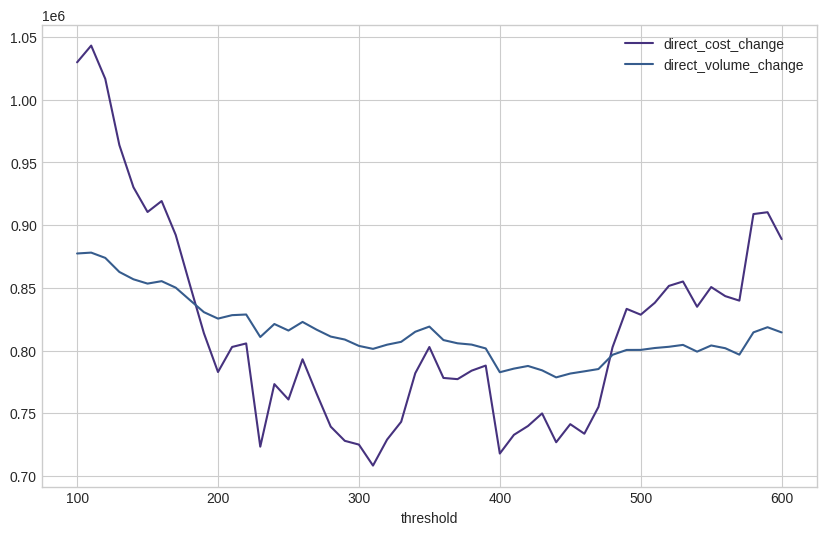

In [ ]:
# Step 6: Analyze feature importance
pipeline.analyze_feature_importance()

# Step 7: Optimize threshold for routing decisions
pipeline.optimize_threshold()

In [ ]:
# Step 8: Compare the new threshold with original threshold
pipeline.compare_the_effect_of_thresholds()

# Step 9: Analyze the metrics and business impact
pipeline.analyze_the_metrics_and_business_impact()

# Step 9: Save the best model
pipeline.save_model()


2.Creating derived features...
Added derived 1 variables. New shapes are: (30755, 40)

400 Annual Threshold distribution:
----------------------------------------------------------
2023: Below threshold: 22832 (74.24%), Above threshold: 7923 (25.76%)
2024: Below threshold: 22720 (73.87%), Above threshold: 8035 (26.13%)
----------------------------------------------------------

The number of customer proportion between thresholds:
----------------------------------------------------------
Below to Above (Growth): 1268 (4.12% of total)
Above to Below (Decline): 1156 (3.76% of total)
Below to Below (No Change): 21564 (70.12% of total)
Above to Above (No Change): 6767 (22.00% of total)
----------------------------------------------------------

3.Current threshold analysis:

If 400 Annual Threshold were applied...


Volume Change
----------------------------------------------------------

Total annumal volume change from 2023 to 2024
2023: 18937111.54 units
2024: 19928814.14 units
Change

### Assumption

- If we are assumed that the price if 1 unit volume is $5, we can compare the delivery cost change and revenue change based on the threshold change.

In [ ]:
net_revenue = (1371834.82 - 1309052.46) * 5 - (2400822.11 - 2113387.14) # annaul volume change * price - delivery cost change
print(f'when 300 threshold applied, growth customers net revenue per annual increases by ${net_revenue:.2f} compared to that of 400 threshold.')

when 300 threshold applied, growth customers net revenue per annual increases by $26476.83 compared to that of 400 threshold.
